# Asthma at NTA Level Data Selection

### Author: Enola Ma

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import re
from matplotlib import pyplot as plt
import contextily as ctx
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import ks_2samp

#### Will likely focus on the average annual rate column:($\frac{average\:anuual\:number\:in\:age\:group}{population\:in\:age\:group}$), but will keep the average annual number column as well. The population used in the fraction above is from NYC DOHMH intercensal estimates.

#### Adults ER visits (2017-2019)

Age-adjusted rate applies a weight to adult 5-year age groups.

In [2]:
#er visits
#adults, 2017-2019
er_18 = pd.read_csv('../Data/asthma_er_18_up_2017_2019.csv')
er_18.head(2)

,Time,GeoTypeDesc,GeoID,GeoRank,Geography,"Average annual age-adjusted rate per 10,000",Average annual number,"Average annual rate per 10,000"
0,2017-2019,Neighborhood Tabulation Area,501,8,Claremont-Bathgate,289.1,712,296.9
1,2017-2019,Neighborhood Tabulation Area,503,8,Eastchester-Edenwald-Baychester,158.4,453,158.4


In [3]:
er_18.dtypes

Time                                            object
GeoTypeDesc                                     object
GeoID                                            int64
GeoRank                                          int64
Geography                                       object
Average annual age-adjusted rate per 10,000    float64
Average annual number                           object
Average annual rate per 10,000                 float64
dtype: object

In [4]:
#convert avg annual number column to int
er_18['Average annual number'] = er_18['Average annual number'].apply(lambda x: re.sub('[^0-9]', '', x)).astype(int)

#### Children 5-17 ER visits (2017-2019)

In [5]:
#er visits
#children 5-17, 2017-2019
er_5 = pd.read_csv('../Data/asthma_er_5_17_2017_2019.csv')
er_5.head(2)

,Time,GeoTypeDesc,GeoID,GeoRank,Geography,Average annual number,"Average annual rate per 10,000"
0,2017-2019,Neighborhood Tabulation Area,501,8,Claremont-Bathgate,298,399.5
1,2017-2019,Neighborhood Tabulation Area,503,8,Eastchester-Edenwald-Baychester,176,271.2


In [6]:
er_5.dtypes

Time                               object
GeoTypeDesc                        object
GeoID                               int64
GeoRank                             int64
Geography                          object
Average annual number               int64
Average annual rate per 10,000    float64
dtype: object

#### Children 5-17 ER visits (2014-2016)

In [7]:
#er visits
#children 5-17, 2017-2019
er_5_ = pd.read_csv('../Data/asthma_er_5_17_2014_2016.csv')
er_5_.head(2)

,Time,GeoTypeDesc,GeoID,GeoRank,Geography,Average annual number,"Average annual rate per 10,000"
0,2014-2016,Neighborhood Tabulation Area,501,8,Claremont-Bathgate,442,576.6
1,2014-2016,Neighborhood Tabulation Area,503,8,Eastchester-Edenwald-Baychester,273,411.7


In [8]:
er_5_.dtypes

Time                              object
GeoTypeDesc                       object
GeoID                              int64
GeoRank                            int64
Geography                         object
Average annual number             object
Average annual rate per 10,000    object
dtype: object

In [9]:
er_5_['Average annual number'] = er_5_['Average annual number'].apply(lambda x: re.sub('[^0-9]', '', x)).astype(int)
er_5_['Average annual rate per 10,000'] = er_5_['Average annual rate per 10,000'].apply(lambda x: re.sub('[^0-9.]', '', x)).astype(float)

#### Children 0-4 ER visits (2014-2016)

In [10]:
er_0 = pd.read_csv('../Data/asthma_er_0_4_2014_2016.csv')
er_0.head(2)

,Time,GeoTypeDesc,GeoID,GeoRank,Geography,"Average annual rate per 10,000",Number
0,2014-2016,Neighborhood Tabulation Area,501,8,Claremont-Bathgate,801.6,762
1,2014-2016,Neighborhood Tabulation Area,503,8,Eastchester-Edenwald-Baychester,451.6,307


In [11]:
er_0.dtypes

Time                              object
GeoTypeDesc                       object
GeoID                              int64
GeoRank                            int64
Geography                         object
Average annual rate per 10,000    object
Number                            object
dtype: object

In [12]:
#convert the avg rate and number columns to float and int, respectively
er_0['Average annual rate per 10,000'] = er_0['Average annual rate per 10,000'].apply(lambda x: re.sub('[^0-9.]', '', x)).astype(float)
er_0['Number'] = er_0['Number'].apply(lambda x: re.sub('[^0-9]', '', x)).astype(int)

#### Check distribution for a) 2017-2019 adults and 5-17 avg rate; b) 2014-2016 5-17 and 0-4 avg rate

In [13]:
#load nta shapefile to join for plotting
#the data above is generated using 2010 NTA
nta = gpd.read_file('../Data/nta_2010/geo_export_d66993ca-6cc0-4ee0-9b66-052e7675b5f0.shp')
nta = nta.to_crs(4326)
nta.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316803,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719299,"POLYGON ((-73.88705 40.88435, -73.88705 40.884..."
2,4.0,Queens,081,QN55,South Ozone Park,8.246139e+07,36708.169305,"POLYGON ((-73.80577 40.68293, -73.80552 40.682..."
3,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661..."
4,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."


In [14]:
nta_df = pd.DataFrame(nta)

In [15]:
#merge er_18 with nta
print(len(er_18))
er_18_g = nta_df.merge(er_18, how='inner', left_on='ntaname', right_on='Geography')
er_18_g = gpd.GeoDataFrame(er_18_g, geometry='geometry')
print(len(er_18_g))
er_18_g.head(2)

188
188


,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Time,GeoTypeDesc,GeoID,GeoRank,Geography,"Average annual age-adjusted rate per 10,000",Average annual number,"Average annual rate per 10,000"
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316803,"POLYGON ((-73.75205 40.70523, -73.75174 40.704...",2017-2019,Neighborhood Tabulation Area,8108,8,St. Albans,86.5,357,85.3
1,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719299,"POLYGON ((-73.88705 40.88435, -73.88705 40.884...",2017-2019,Neighborhood Tabulation Area,528,8,Van Cortlandt Village,90.3,351,90.2


In [16]:
#merge er_5 with nta
print(len(er_5))
er_5_g = nta_df.merge(er_5, how='inner', left_on='ntaname', right_on='Geography')
er_5_g = gpd.GeoDataFrame(er_5_g, geometry='geometry')
print(len(er_5_g))
er_5_g.head(2)

188
188


,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Time,GeoTypeDesc,GeoID,GeoRank,Geography,Average annual number,"Average annual rate per 10,000"
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316803,"POLYGON ((-73.75205 40.70523, -73.75174 40.704...",2017-2019,Neighborhood Tabulation Area,8108,8,St. Albans,118,157.1
1,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719299,"POLYGON ((-73.88705 40.88435, -73.88705 40.884...",2017-2019,Neighborhood Tabulation Area,528,8,Van Cortlandt Village,194,239.7


Text(0.5, 1.0, 'Children 5-17 Annual Average Rate (Rep. All Children), 2017-2019')

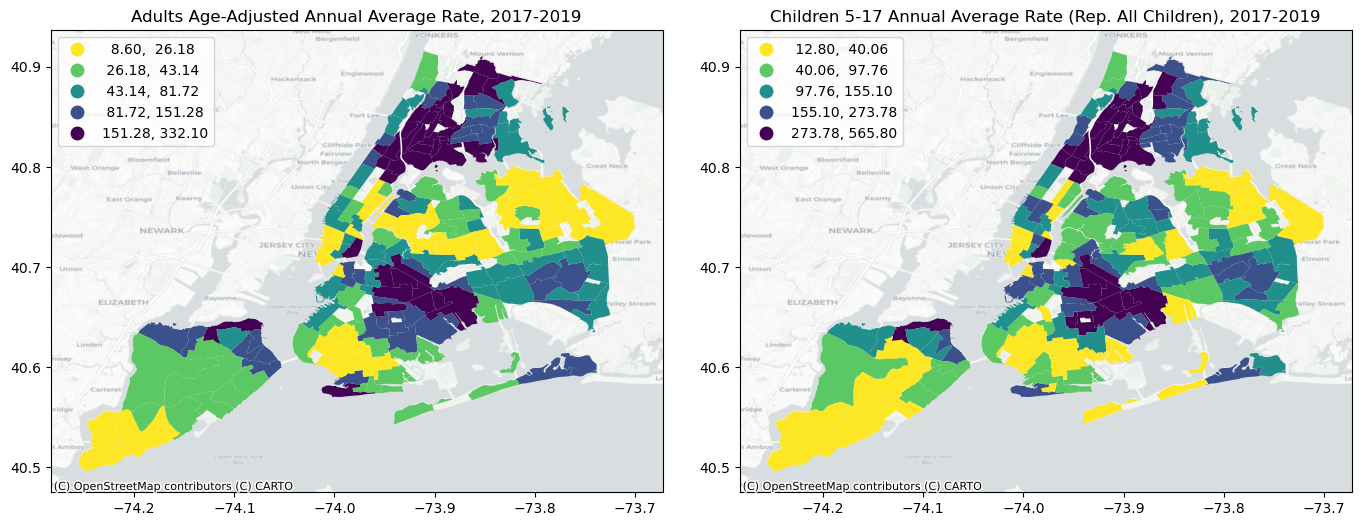

In [35]:
#plot
#er_18_g; er_5_g
fig, ax = plt.subplots(ncols=2, figsize=(20,6), gridspec_kw = {'wspace':-0.2})
er_18_g.plot(column='Average annual age-adjusted rate per 10,000', ax=ax[0], legend=True, scheme='quantiles', 
            legend_kwds={'loc':'upper left'}, cmap='viridis_r')
er_5_g.plot(column='Average annual rate per 10,000', ax=ax[1], legend=True, scheme='quantiles',
           legend_kwds={'loc':'upper left'}, cmap='viridis_r')
ctx.add_basemap(ax[0], crs=4326, source=ctx.providers.CartoDB.Positron,alpha=0.9)
ctx.add_basemap(ax[1], crs=4326, source=ctx.providers.CartoDB.Positron,alpha=0.9)
ax[0].set_title('Adults Age-Adjusted Annual Average Rate, 2017-2019')
ax[1].set_title('Children 5-17 Annual Average Rate (Rep. All Children), 2017-2019')

In [18]:
#ks-test for the two distributions
ks_2samp(er_18_g['Average annual age-adjusted rate per 10,000'], er_5_g['Average annual rate per 10,000'])

KstestResult(statistic=0.2872340425531915, pvalue=3.0738517417008196e-07, statistic_location=93.6, statistic_sign=1)

##### The p-value from the ks-test above indicates that the two distributions are statistically different

In [19]:
#merge er_5_ with nta
print(len(er_5_))
er_5_g_ = nta_df.merge(er_5_, how='inner', left_on='ntaname', right_on='Geography')
er_5_g_ = gpd.GeoDataFrame(er_5_g_, geometry='geometry')
print(len(er_5_g_))
er_5_g_.head(2)

188
188


,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Time,GeoTypeDesc,GeoID,GeoRank,Geography,Average annual number,"Average annual rate per 10,000"
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316803,"POLYGON ((-73.75205 40.70523, -73.75174 40.704...",2014-2016,Neighborhood Tabulation Area,8108,8,St. Albans,138,160.1
1,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719299,"POLYGON ((-73.88705 40.88435, -73.88705 40.884...",2014-2016,Neighborhood Tabulation Area,528,8,Van Cortlandt Village,243,288.6


In [20]:
#merge er_0 with nta
print(len(er_0))
er_0_g = nta_df.merge(er_0, how='inner', left_on='ntaname', right_on='Geography')
er_0_g = gpd.GeoDataFrame(er_0_g, geometry='geometry')
print(len(er_0_g))
er_0_g.head(2)

188
188


,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,Time,GeoTypeDesc,GeoID,GeoRank,Geography,"Average annual rate per 10,000",Number
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316803,"POLYGON ((-73.75205 40.70523, -73.75174 40.704...",2014-2016,Neighborhood Tabulation Area,8108,8,St. Albans,301.3,277
1,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719299,"POLYGON ((-73.88705 40.88435, -73.88705 40.884...",2014-2016,Neighborhood Tabulation Area,528,8,Van Cortlandt Village,508.6,563


Text(0.5, 1.0, 'Children 0-4, 2014-2016')

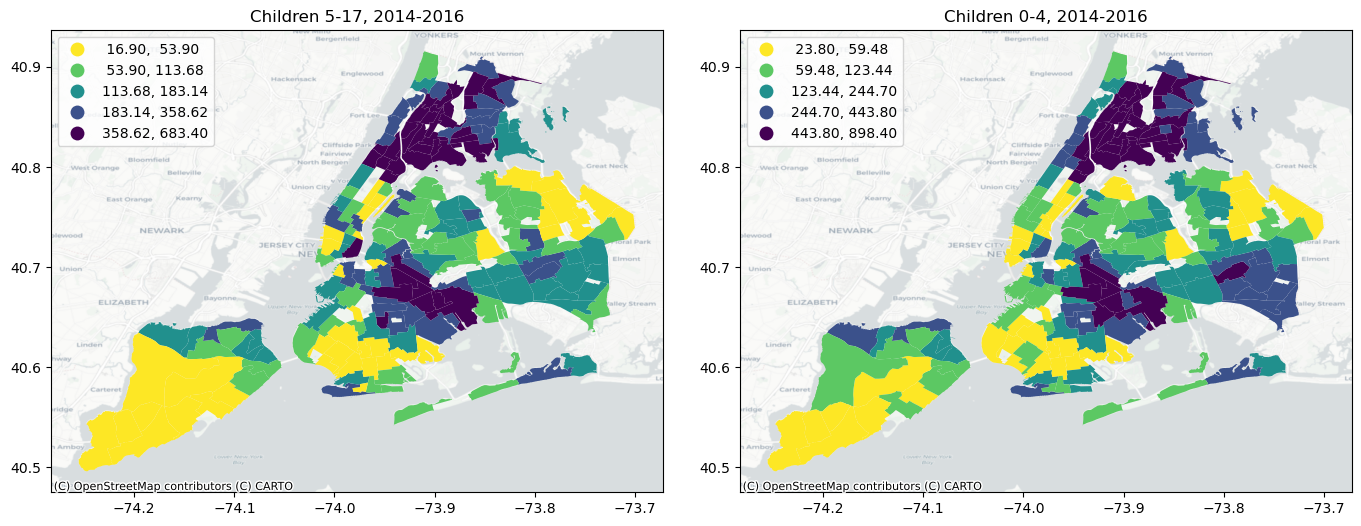

In [21]:
#plot
#er_5_g_; er_0_g
fig, ax = plt.subplots(ncols=2, figsize=(20,6), gridspec_kw = {'wspace':-0.2})
er_5_g_.plot(column='Average annual rate per 10,000', ax=ax[0], legend=True, scheme='quantiles',
           legend_kwds={'loc':'upper left'}, cmap='viridis_r')
er_0_g.plot(column='Average annual rate per 10,000', ax=ax[1], legend=True, scheme='quantiles', 
            legend_kwds={'loc':'upper left'}, cmap='viridis_r')
ctx.add_basemap(ax[0], crs=4326, source=ctx.providers.CartoDB.Positron,alpha=0.9)
ctx.add_basemap(ax[1], crs=4326, source=ctx.providers.CartoDB.Positron,alpha=0.9)
ax[0].set_title('Children 5-17, 2014-2016')
ax[1].set_title('Children 0-4, 2014-2016')

In [22]:
#ks-test for the two distributions
ks_2samp(er_5_g_['Average annual rate per 10,000'], er_0_g['Average annual rate per 10,000'])

KstestResult(statistic=0.14361702127659576, pvalue=0.041272496010078215, statistic_location=446.2, statistic_sign=1)

##### While the p-value from the ks-test above is lower than the 5% significance level, it is not completely far off compared to the first ks-test we performed. For the purpose of this study, we will use the 2-17-2019 asthma data for children 5-17 to represent the asthma outcome for all children. However, it is worth noting that we are assuming children's asthma outcome stayed the same since 2016.

There is no 2017-2019 asthma ER visits data for children aged 4 and under at NTA level. However, the citywide data is available. Therefore, we will need to assume every NTA followed the citywide trend and extrapolate the data this way. Since the NYCDOH website only reports the average annual rate per 10,000, we will multiply the 2014-2016 data by the ratio of the citywide $\frac{mean(2017-2019)}{mean(2012-2014)}$ to infer the NTA level data for this age group for 2017-2019.

In [23]:
# #calculate means for the two periods
# m_2014_2016 = np.mean([319.8, 307, 292.6])
# m_2017_2019 = np.mean([253.7, 240.3, 194.7])
# ratio = m_2017_2019/m_2014_2016
# ratio

In [24]:
# er_0 = pd.read_csv('../Data/asthma_er_0_4_2014_2016.csv')
# er_0.head(2)

In [25]:
# er_0.dtypes

In [26]:
# #convert the avg rate and number columns to float and int, respectively
# er_0['Average annual rate per 10,000'] = er_0['Average annual rate per 10,000'].apply(lambda x: re.sub('[^0-9.]', '', x)).astype(float)
# er_0['Average annual rate per 10,000'] = round(er_0['Average annual rate per 10,000']*ratio, 1)
# er_0['Number'] = er_0['Number'].apply(lambda x: re.sub('[^0-9]', '', x)).astype(int)
# er_0['Number'] = (er_0['Number']*ratio).astype(int)
# er_0.head(2)

#### Combine the adults and children 5-17 2017-2019 dataframes

asth_{ }_{ }: 
- a for adult; c for children
- n for number; r for rate per 10,000\

asth_a_a_r: age-adjusted rate per 10,000 for pop 18 and over

In [27]:
df1 = er_18[['Geography', 'Average annual age-adjusted rate per 10,000', 'Average annual number', 'Average annual rate per 10,000']]
df1 = df1.rename(columns={'Average annual age-adjusted rate per 10,000':'asth_a_a_r',
                          'Average annual number':'asth_a_n',
                          'Average annual rate per 10,000':'asth_a_r'})
print(len(df1))
df1.head(2)

188


,Geography,asth_a_a_r,asth_a_n,asth_a_r
0,Claremont-Bathgate,289.1,712,296.9
1,Eastchester-Edenwald-Baychester,158.4,453,158.4


In [28]:
df2 = er_5[['Geography', 'Average annual number', 'Average annual rate per 10,000']]
df2 = df2.rename(columns={'Average annual number':'asth_c_n',
                          'Average annual rate per 10,000':'asth_c_r'})
print(len(df2))
df2.head(2)

188


,Geography,asth_c_n,asth_c_r
0,Claremont-Bathgate,298,399.5
1,Eastchester-Edenwald-Baychester,176,271.2


In [29]:
mer = df1.merge(df2, how='inner', on='Geography')
print(len(mer))
mer.head(2)

188


,Geography,asth_a_a_r,asth_a_n,asth_a_r,asth_c_n,asth_c_r
0,Claremont-Bathgate,289.1,712,296.9,298,399.5
1,Eastchester-Edenwald-Baychester,158.4,453,158.4,176,271.2


In [30]:
#check that nta names match 
print(len(set(nta_df['ntaname']).intersection(set(mer['Geography']))))

188


In [31]:
#merge mer with nta
nta_m = nta_df.merge(mer, how='inner', left_on='ntaname', right_on='Geography')
nta_m = nta_m[['boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname', 
             'asth_a_a_r', 'asth_a_n', 'asth_a_r', 'asth_c_n', 'asth_c_r', 'geometry']]
print(len(nta_m))
nta_m.head(2)

188


,boro_code,boro_name,county_fip,ntacode,ntaname,asth_a_a_r,asth_a_n,asth_a_r,asth_c_n,asth_c_r,geometry
0,4.0,Queens,081,QN08,St. Albans,86.5,357,85.3,118,157.1,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,2.0,Bronx,005,BX28,Van Cortlandt Village,90.3,351,90.2,194,239.7,"POLYGON ((-73.88705 40.88435, -73.88705 40.884..."


In [32]:
nta_m_gdf = gpd.GeoDataFrame(nta_m, geometry='geometry')
nta_m_gdf = nta_m_gdf.set_crs(4326, allow_override=True)
nta_m_gdf.head(2)

,boro_code,boro_name,county_fip,ntacode,ntaname,asth_a_a_r,asth_a_n,asth_a_r,asth_c_n,asth_c_r,geometry
0,4.0,Queens,081,QN08,St. Albans,86.5,357,85.3,118,157.1,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,2.0,Bronx,005,BX28,Van Cortlandt Village,90.3,351,90.2,194,239.7,"POLYGON ((-73.88705 40.88435, -73.88705 40.884..."


In [33]:
nta_m_gdf.to_file('../Data/asthma_er_nta/asthma_er_nta.shp')